# Bitcoin & Ethereum Explore
We're going to employ a **Long Short Term Memory (LSTM)** model; it's a particular type of deep learning model that is well suited to time series data (or any data with temporal/spatial/structural order e.g. movies, sentences, etc.). 

# Data

> dataset on Kaggle: https://www.kaggle.com/mczielinski/bitcoin-historical-data  
  Bitcoin prices by minute for the last few years

Over this timescale, noise could overwhelm the signal, so we'll opt for daily prices. The issue here is that we may have not sufficient data (we'll have hundreds of rows rather than thousands or millions). In deep learning, no model can overcome a severe lack of data.  
I also don't want to rely on static files, as that'll complicate the process of updating the model in the future with new data. Instead, we'll aim to pull data from websites and APIs.  
As we'll be combining multiple cryptos in one model, it's probably a good idea to pull the data from one source. We'll use [coinmarketcap.com](https://coinmarketcap.com). 

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Bitcoin information

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))

# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0

# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')

# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-20,8286.88,8880.23,8244.54,8845.83,8438110000,140777000000
1,2018-04-19,8159.27,8298.69,8138.78,8294.31,7063210000,138591000000
2,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000
3,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000
4,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000


# Ethereum information

In [3]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-20,567.99,618.72,560.28,615.72,2849470000,56188700000
1,2018-04-19,524.04,567.89,523.26,567.89,2256870000,51829900000
2,2018-04-18,503.31,525.09,503.05,524.79,1762940000,49769600000
3,2018-04-17,511.14,518.03,502.56,502.89,1760360000,50534000000
4,2018-04-16,532.07,534.20,500.25,511.15,1758980000,52592200000


# Graph for price changing

In [4]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

import urllib2 as urllib
bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [5]:
# rename columns to differentiate the column names for two coins
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [6]:
def plot_coin_info(coin_market_info, prefix, logo_img, img_x, img_y):
    sns.set()
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, sharex=True, figsize=(12, 9))
    ax1.set_ylabel('Closing Price ($)',fontsize=12)
    ax2.set_ylabel('Volume ($ bn)',fontsize=12)
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(coin_market_info['Date'].astype(datetime.datetime), coin_market_info['%s_Open' %(prefix)])
    ax2.bar(coin_market_info['Date'].astype(datetime.datetime).values, 
            coin_market_info['%s_Volume' %(prefix)].values, color='black')
    fig.tight_layout()
    fig.figimage(logo_img, img_x, img_y, zorder=3,alpha=.5)
    plt.show()

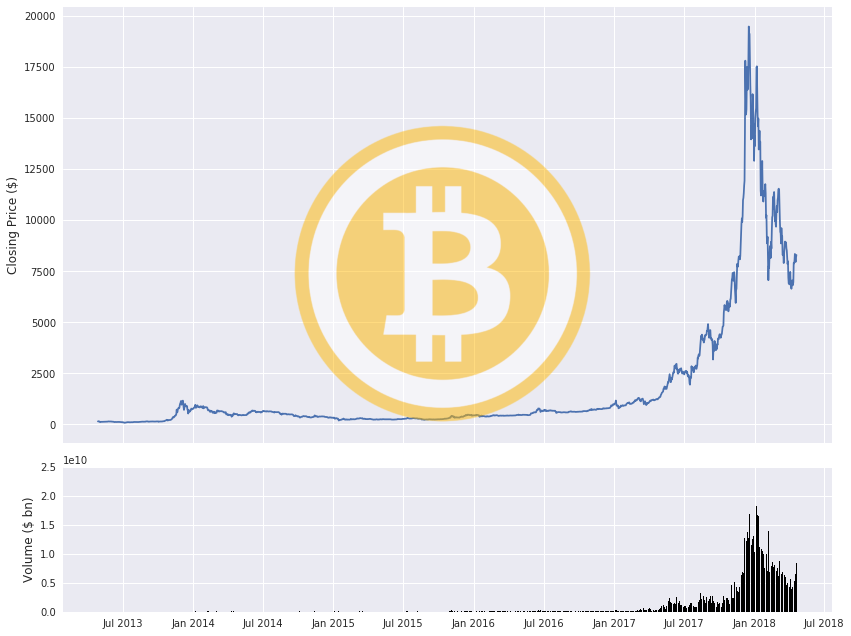

In [7]:
plot_coin_info(bitcoin_market_info, 'bt', bitcoin_im, 120, 120)

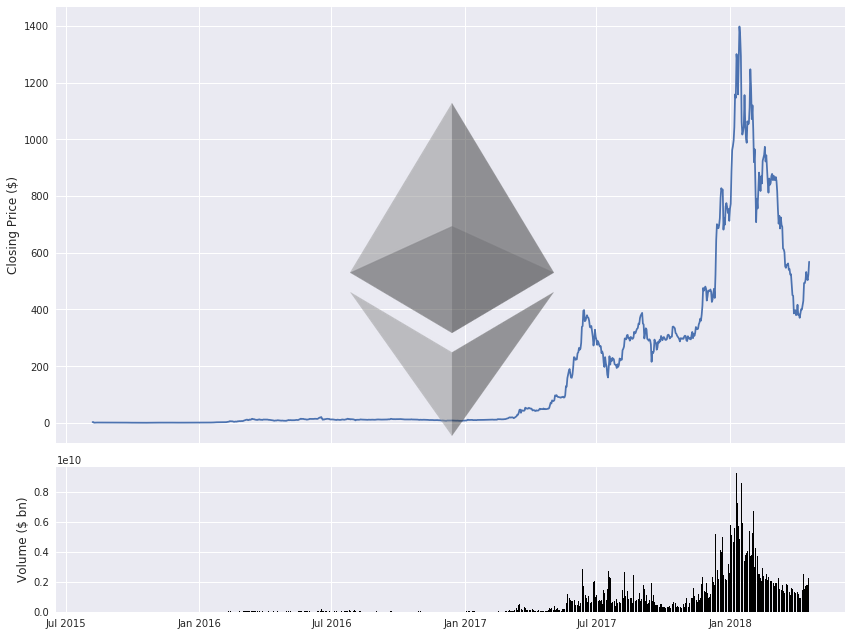

In [8]:
plot_coin_info(eth_market_info, 'eth', eth_im, 350, 200)

In [9]:
# only take records starting from 2016
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']

for coins in ['bt_', 'eth_']: 
    kwargs = {coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-04-20,8286.88,8880.23,8244.54,8845.83,8438110000,140777000000,567.99,618.72,560.28,615.72,2849470000,56188700000,0.067450,0.084033
1,2018-04-19,8159.27,8298.69,8138.78,8294.31,7063210000,138591000000,524.04,567.89,523.26,567.89,2256870000,51829900000,0.016551,0.083677
2,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000,503.31,525.09,503.05,524.79,1762940000,49769600000,0.027565,0.042677
3,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000,511.14,518.03,502.56,502.89,1760360000,50534000000,-0.021008,-0.016140
4,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000,532.07,534.20,500.25,511.15,1758980000,52592200000,-0.033451,-0.039318


# Training, Test & Random Walks

In time series models, we generally train on one period of time and then test on another separate period. Rather arbitrarily, I'll set the **cut-off date** to June 1st 2017 (i.e. model will be trained on data before that date and assessed on data after it).

In [10]:
def draw_train_test(split_date, ax, prefix, y_label, logo_img, img_x, img_y):
    ax.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
            market_info[market_info['Date'] < split_date]['%s_Close' %(prefix)], 
            color='#B08FC7', label='Training')
    ax.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
            market_info[market_info['Date'] >= split_date]['%s_Close' %(prefix)], 
            color='#8FBAC8', label='Test')
    ax.set_ylabel(y_label,fontsize=12)

    fig.figimage(logo_img.resize((int(logo_img.size[0]*0.65), int(logo_img.size[1]*0.65)), Image.ANTIALIAS), 
                 img_x, img_y, zorder=3, alpha=.5)

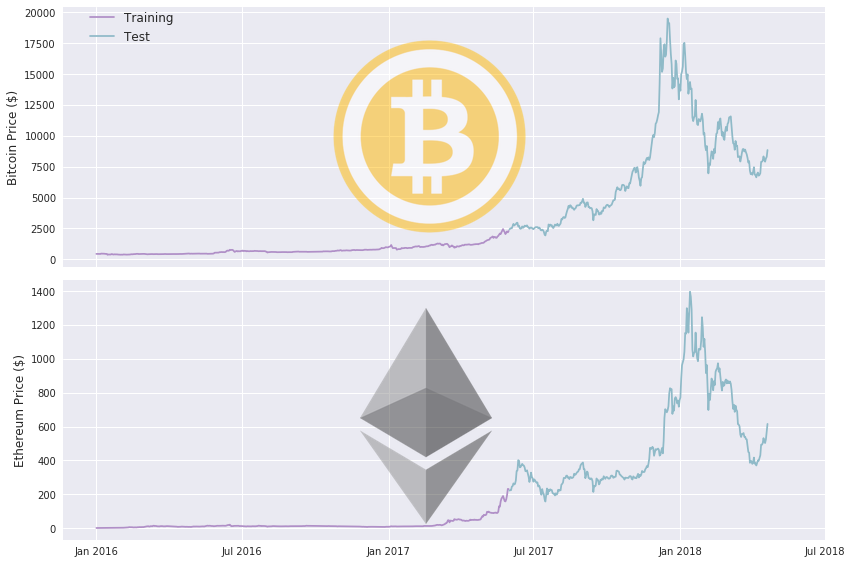

In [11]:
split_date = '2017-06-01'
sns.set()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8))
draw_train_test(split_date, ax1, 'bt', 'Bitcoin Price ($)', bitcoin_im, 220, 270)
draw_train_test(split_date, ax2, 'eth', 'Ethereum Price ($)', eth_im, 360, 40)

ax1.set_xticks([datetime.date(i,j,1) for i in range(2016,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2016,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y') for i in range(2016,2019) for j in [1,7]])

plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 12})
plt.show()

> You can see that the training period mostly consists of periods when cryptos were relatively cheaper. As such, the training data may not be representative of the test data, undermining the model's ability to generalise to unseen data.

# useful function to display prediction performance

In [12]:
def overlay_predict_actual(x, y_actual, y_pred, ax, y_label):
    ax.plot(x, y_actual, label='Actual')
    ax.plot(x, y_pred, label='Predict')
    ax.set_ylabel(y_label, fontsize=12)
    
def draw_pred_performance(x, bt_actual, bt_pred, eth_actual, eth_pred, title):
    sns.set()
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8), sharex=True)
    overlay_predict_actual(x, bt_actual, bt_pred, ax1, 'Bitcoin Price ($)')
    overlay_predict_actual(x, eth_actual, eth_pred, ax2, 'Etherum Price ($)')
    
    xticks = []
    for year in range(2017, 2019):
        if year == 2017:
            months = range(6, 13)
        if year == 2018:
            months = range(1, 6)
        for m in months:
            xticks.append(datetime.date(year, m, 1))
    
    ax1.set_xticks(xticks)
    ax1.set_xticklabels('')
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([xtick.strftime('%b %Y') for xtick in xticks])

    ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size': 12})
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

# trivial lag model: P_t = P_(t-1)
Before we take our deep artificially intelligent machine learning model to the moon, it's worth discussing a simpler model. The most basic model is to set tomorrow's price equal to today's price (which we'll crudely call a lag model). This is how we'd define such a model in mathematical terms:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1}
\end{align}

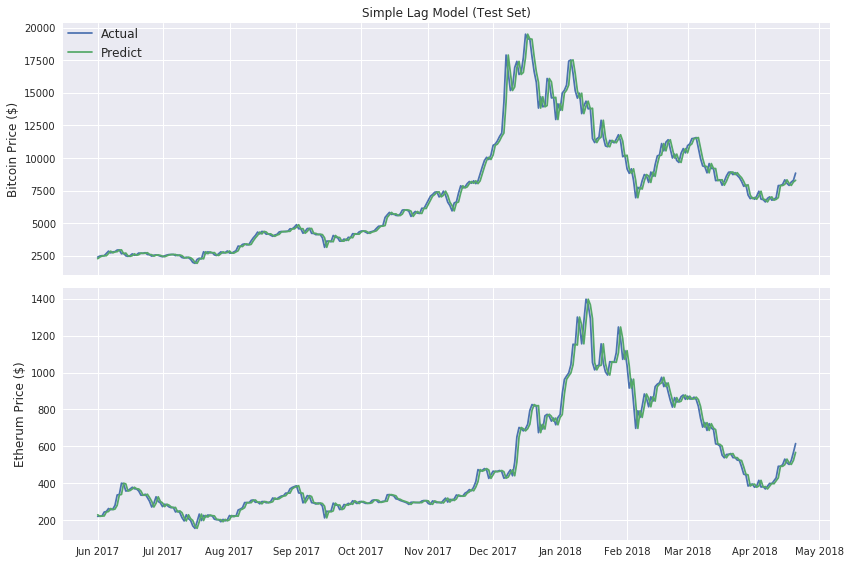

In [13]:
x = market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime)
bt_actual = market_info[market_info['Date']>= split_date]['bt_Close'].values
bt_pred = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values
eth_actual = market_info[market_info['Date']>= split_date]['eth_Close'].values
eth_pred = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                       datetime.timedelta(days=1)]['eth_Close'][1:].values

draw_pred_performance(x, bt_actual, bt_pred, eth_actual, eth_pred, 'Simple Lag Model (Test Set)')

# Random Walks
Extending this trivial lag model, [stock prices are commonly treated as random walks](https://www.tcd.ie/Economics/assets/pdf/SER/2007/Samuel_Dupernex.pdf), which can be defined in these mathematical terms:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)
\end{align}

We'll determine &mu; and &sigma; from the training sets and apply the random walk model to the Bitcoin and Ethereum test sets.

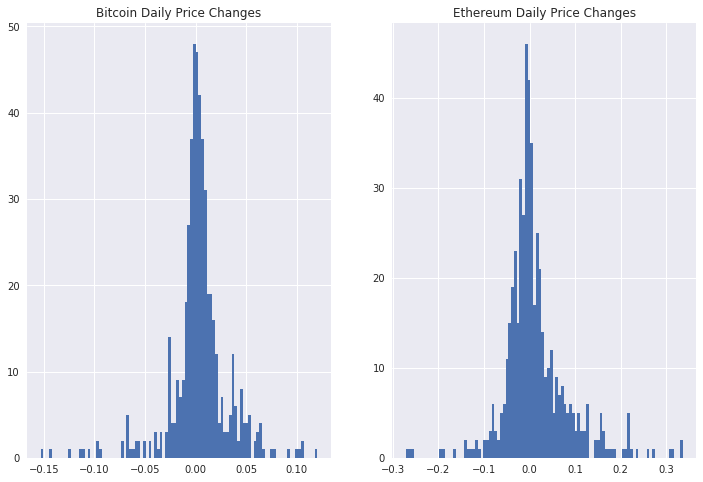

In [14]:
sns.set()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

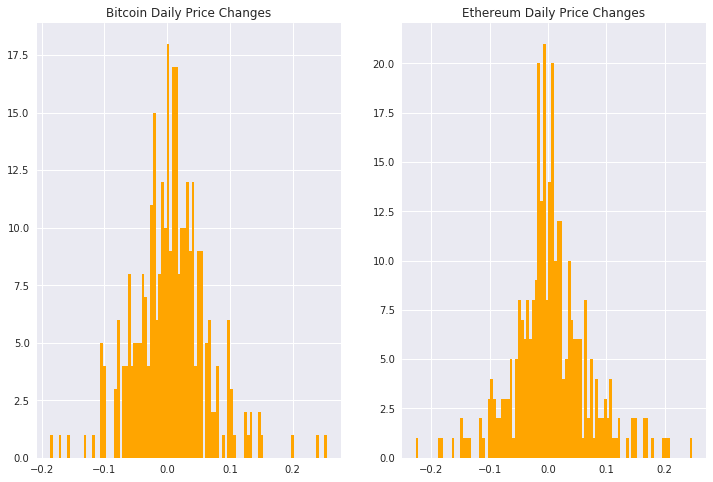

In [15]:
sns.set()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
ax1.hist(market_info[market_info['Date']>= split_date]['bt_day_diff'].values, bins=100, color='orange')
ax2.hist(market_info[market_info['Date']>= split_date]['eth_day_diff'].values, bins=100, color='orange')
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

In [16]:
def random_walks(prefix, num_pred_days):
    r_walk_mean = np.mean(market_info[market_info['Date'] < split_date]['%s_day_diff' %(prefix)].values)
    r_walk_sd = np.std(market_info[market_info['Date'] < split_date]['%s_day_diff' %(prefix)].values)
    random_steps = np.random.normal(r_walk_mean, r_walk_sd, num_pred_days)
    
    return random_steps

In [17]:
#apply random walks
np.random.seed(202)
num_pred_days = (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1

bt_random_steps = random_walks('bt', num_pred_days)
eth_random_steps = random_walks('eth', num_pred_days)

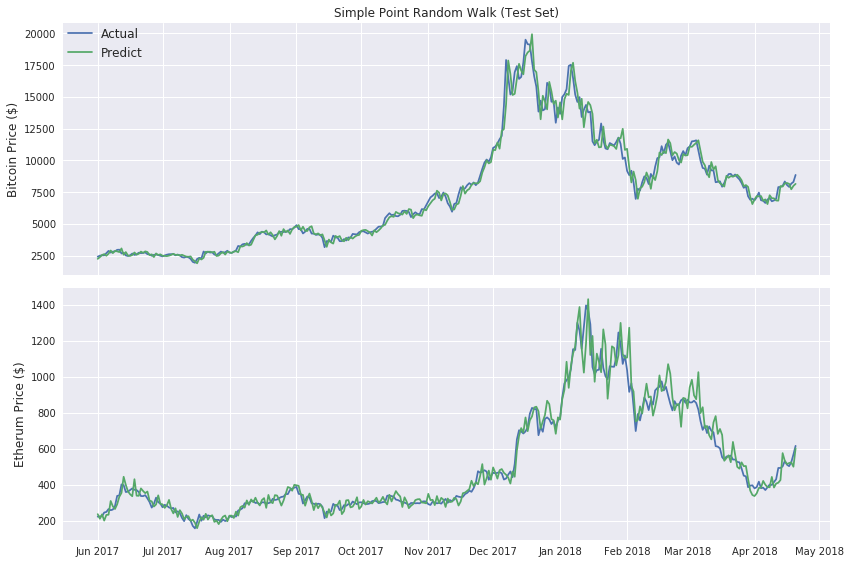

In [18]:
x = market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime)
bt_actual = market_info[market_info['Date']>= split_date]['bt_Close'].values
bt_pred = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values * (1 + bt_random_steps)
eth_actual = market_info[market_info['Date']>= split_date]['eth_Close'].values
eth_pred = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                       datetime.timedelta(days=1)]['eth_Close'][1:].values * (1 + eth_random_steps)

draw_pred_performance(x, bt_actual, bt_pred, eth_actual, eth_pred, 'Simple Point Random Walk (Test Set)')

> Wow! Look at those prediction lines. Apart from a few kinks, it broadly tracks the actual closing price for each coin. It even captures the eth rises (and subsequent falls) in mid-June and late August.  

As pointed out on that other blog, models that only make predictions one point into the future are often **misleadingly accurate**, as errors aren't carried over to subsequent predictions.   
No matter how large the error, it's essentially reset at each time point, as the model is fed the true price. The Bitcoin random walk is particularly deceptive, **as the scale of the y-axis is quite wide**, making the prediction line appear quite smooth.  

# Overcome the deceptive result
**Single point predictions** are unfortunately quite common when evaluating time series models (e.g.[here](https://medium.com/@binsumi/neural-networks-and-bitcoin-d452bfd7757e) and [here](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)).   
A better idea could be to **measure its accuracy on multi-point predictions**. That way, errors from previous predictions aren't reset but rather are compounded by subsequent predictions. Thus, poor models are penalised more heavily. In mathematical terms:

\begin{align}
PredPrice_{t} & = PredPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)\ \&  \ PredPrice_0 = Price_0
\end{align}

Let's get our random walk model to predict the closing prices over the total test set.

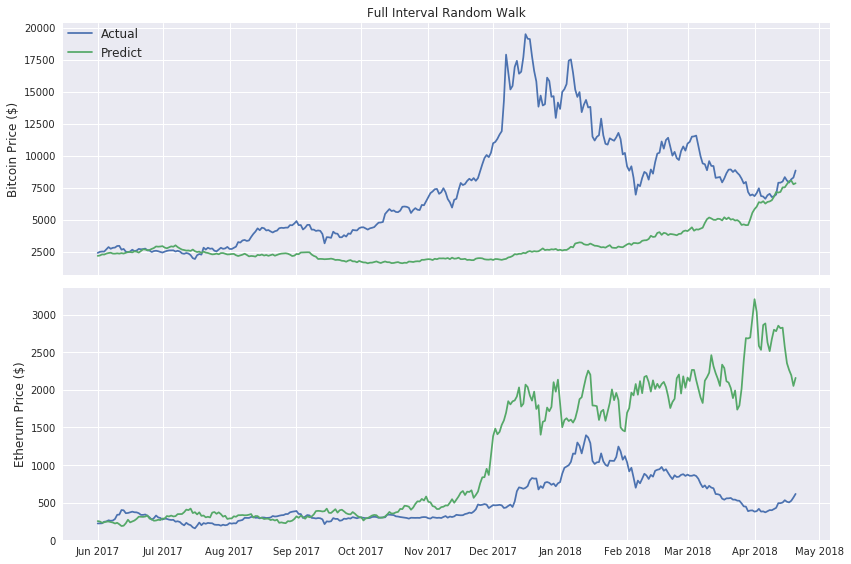

In [19]:
#apply random walks
np.random.seed(100)
num_pred_days = (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1

bt_random_steps = random_walks('bt', num_pred_days)
eth_random_steps = random_walks('eth', num_pred_days)

x = market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime)
bt_actual = market_info[market_info['Date']>= split_date]['bt_Close'].values
eth_actual = market_info[market_info['Date']>= split_date]['eth_Close'].values

bt_random_walk = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))

draw_pred_performance(x, bt_actual, bt_random_walk[::-1], eth_actual, eth_random_walk[::-1], 'Full Interval Random Walk')

> The model predictions are extremely sensitive to the random seed. I've selected one where the full interval random walk looks almost decent for Ethereum. In the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb), you can interactively play around with the seed value below to see how badly it can perform.

> Notice how the single point random walk always looks quite accurate, even though there's no real substance behind it. Hopefully, you'll be more suspicious of any blog that claims to accurately predict prices. I probably shouldn't worry; it's not like crypto fans to be seduced by [slick marketing claims](https://uetoken.com/).